# Processus Gaussien pour prédiction poids

### Librairies

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

### Données brutes

In [43]:
file_save = os.getcwd() + "/data/dataset.csv"

with open(file_save, 'r') as f:
    df = pd.read_csv(file_save, index_col=0)

In [44]:
df

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2020-08-09,107.250000,37.190000,NaN,NaN,NaN,0.346760,1883.296000,1861.3,71.3,245.0,66.1,0.000,0.0,0.000000,1883.296000,-21.996000
2020-08-11,104.650000,33.150000,NaN,NaN,NaN,0.316770,1914.400000,1772.4,50.5,185.8,104.1,0.000,0.0,0.000000,1914.400000,-142.000000
2020-08-12,104.350000,33.800000,NaN,NaN,NaN,0.323910,1893.880000,1894.3,59.3,220.3,87.5,0.000,0.0,0.000000,1893.880000,0.420000
2020-08-13,104.400000,34.340000,NaN,NaN,NaN,0.328927,1883.296000,1822.6,71.5,227.7,70.2,0.000,0.0,0.000000,1883.296000,-60.696000
2020-08-14,104.500000,33.850000,NaN,NaN,NaN,0.323923,1896.040000,1891.5,61.8,217.2,82.5,0.000,0.0,0.000000,1896.040000,-4.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13,70.830000,11.471111,2.968889,56.373333,39.606667,0.161953,1652.152000,1853.7,51.2,143.3,216.6,2257.087,254.0,210.839690,1862.991690,-9.291690
2023-11-14,71.056667,11.332222,2.987778,56.717778,39.991111,0.159481,1660.048000,1715.3,36.2,154.0,211.0,1500.828,281.0,252.163813,1912.211813,-196.911813
2023-11-15,70.258750,11.072500,2.961250,56.208750,39.525000,0.157596,1648.423000,1654.8,45.5,135.1,186.2,3671.210,396.0,325.957095,1974.380095,-319.580095
2023-11-16,70.404286,11.120000,2.967143,56.301429,39.607143,0.157945,1650.540571,1778.7,54.4,128.2,204.9,0.000,0.0,0.000000,1650.540571,128.159429


In [45]:
# clean-up
df1 = df.copy(deep=True)
columns_to_drop = ['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique', 'MG%', 'BMR', 'Lipides', 'Glucides', 'Proteines', 'exo_duree', 'exo_cals_bruts', 'Depense_cal_totale', 'cal_deficit']
df1.drop(columns=columns_to_drop, inplace=True)

In [46]:
df1

,Masse_Totale,Masse_Grasse,Calories,exo_cals_nets
2020-08-09,107.250000,37.190000,1861.3,0.000000
2020-08-11,104.650000,33.150000,1772.4,0.000000
2020-08-12,104.350000,33.800000,1894.3,0.000000
2020-08-13,104.400000,34.340000,1822.6,0.000000
2020-08-14,104.500000,33.850000,1891.5,0.000000
...,...,...,...,...
2023-11-13,70.830000,11.471111,1853.7,210.839690
2023-11-14,71.056667,11.332222,1715.3,252.163813
2023-11-15,70.258750,11.072500,1654.8,325.957095
2023-11-16,70.404286,11.120000,1778.7,0.000000


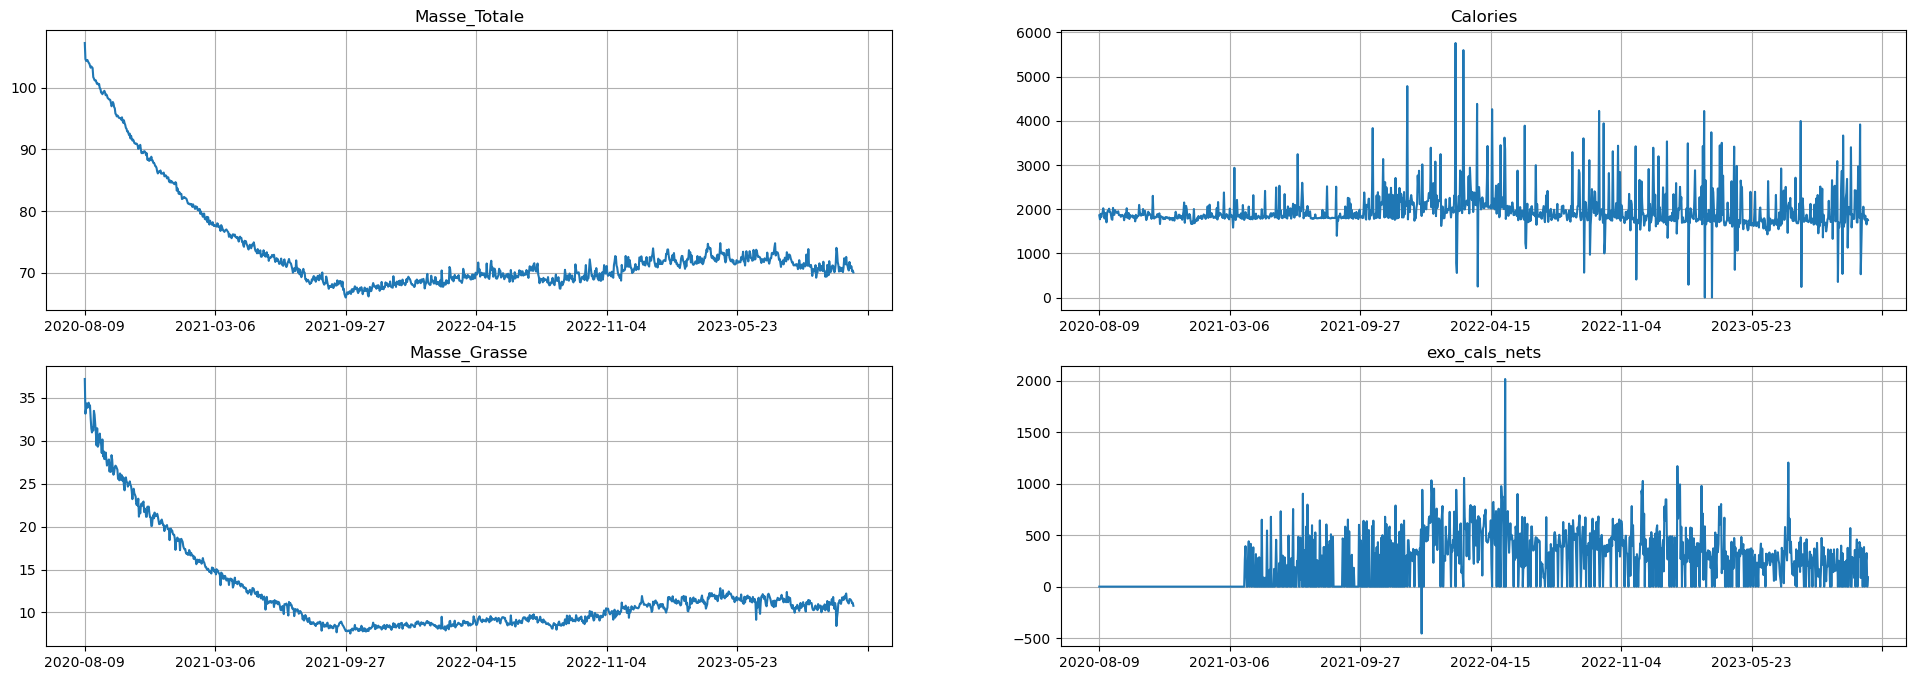

In [47]:
# Visu

fig, axs = plt.subplots(2,2,figsize=(24,8))

for i,name in enumerate(df1.columns):
    r = i%2
    c = i//2
    axs[r,c].set_title(name)
    df1[name].plot(ax=axs[r,c])
    axs[r,c].grid(True)

In [48]:
# need to check that datapoints follow by one day
# and deal with holes

## Création du dataset

In [49]:
# create dataset.
# targets are next day's Masse_Totale and Masse_Grasse values
# no averaging

df1 = pd.concat([df1.shift(1), df1['Masse_Totale'], df['Masse_Grasse']], axis=1)
df1.columns = ['MT', 'MG', 'Cals', 'Exos', 'MT+1', 'MG+1']
df1.dropna(inplace=True)

In [50]:
df2 = df1.copy(deep=True)

df2

,MT,MG,Cals,Exos,MT+1,MG+1
2020-08-11,107.250000,37.190000,1861.3,0.000000,104.650000,33.150000
2020-08-12,104.650000,33.150000,1772.4,0.000000,104.350000,33.800000
2020-08-13,104.350000,33.800000,1894.3,0.000000,104.400000,34.340000
2020-08-14,104.400000,34.340000,1822.6,0.000000,104.500000,33.850000
2020-08-15,104.500000,33.850000,1891.5,0.000000,104.250000,34.280000
...,...,...,...,...,...,...
2023-11-13,71.212222,11.544444,1765.3,0.000000,70.830000,11.471111
2023-11-14,70.830000,11.471111,1853.7,210.839690,71.056667,11.332222
2023-11-15,71.056667,11.332222,1715.3,252.163813,70.258750,11.072500
2023-11-16,70.258750,11.072500,1654.8,325.957095,70.404286,11.120000


### Premier hyper-paramètre : date de démarrage des données d'entraînement

In [51]:
year = 2020
month = 9
day = 1

In [52]:
from datetime import datetime

def crop_dataset(df=df2, year=year, month=month, day=day):
    """supprime les données avant year,month, date
    """
    df.index = pd.to_datetime(df.index)
    df = df[df.index >= datetime(year=year, month=month, day=day)]
    return df

In [53]:
df2 = crop_dataset().copy(deep=True)

df2

,MT,MG,Cals,Exos,MT+1,MG+1
2020-09-01,101.500000,33.480000,1951.3,0.000000,101.225000,33.020000
2020-09-02,101.225000,33.020000,2012.9,0.000000,101.150000,31.945000
2020-09-03,101.150000,31.945000,1940.0,0.000000,101.200000,30.930000
2020-09-04,101.200000,30.930000,1936.9,0.000000,100.800000,29.460000
2020-09-05,100.800000,29.460000,1851.2,0.000000,100.600000,31.450000
...,...,...,...,...,...,...
2023-11-13,71.212222,11.544444,1765.3,0.000000,70.830000,11.471111
2023-11-14,70.830000,11.471111,1853.7,210.839690,71.056667,11.332222
2023-11-15,71.056667,11.332222,1715.3,252.163813,70.258750,11.072500
2023-11-16,70.258750,11.072500,1654.8,325.957095,70.404286,11.120000


### Deuxième hyper-paramètre : moyenne des données

In [54]:
length_average = 3

In [55]:
def get_df_moyenne(df=df2, length_average=length_average):
    """prend la dataframe et moyenne les valeurs suivant length_average"""
    df = df2.rolling(window=length_average).mean()
    df.dropna(inplace=True)
    return df

In [56]:
df2 = get_df_moyenne()

df2

,MT,MG,Cals,Exos,MT+1,MG+1
2020-09-03,101.291667,32.815000,1968.066667,0.000000,101.191667,31.965000
2020-09-04,101.191667,31.965000,1963.266667,0.000000,101.050000,30.778333
2020-09-05,101.050000,30.778333,1909.366667,0.000000,100.866667,30.613333
2020-09-06,100.866667,30.613333,1853.400000,0.000000,100.700000,30.070000
2020-09-07,100.700000,30.070000,1794.733333,0.000000,100.600000,30.086667
...,...,...,...,...,...,...
2023-11-13,71.120503,11.383803,1886.600000,202.008472,71.269074,11.525602
2023-11-14,71.269074,11.525602,1818.933333,198.528621,71.032963,11.449259
2023-11-15,71.032963,11.449259,1778.100000,154.334501,70.715139,11.291944
2023-11-16,70.715139,11.291944,1741.266667,262.986866,70.573234,11.174907


### Construit les train et test sets

In [57]:
X = df2[['MT', 'MG', 'Cals', 'Exos']]
y_mt = df2['MT+1']
y_mg = df2['MG+1']

### Troisième hyper-paramètre : longueur du test set (par défaut 30 derniers jours)

In [58]:
LAST = 90

In [59]:
X_train = X[:-LAST]
X_test = X[-LAST:]

y_mt_train = y_mt[:-LAST]
y_mt_test = y_mt[-LAST:]

y_mg_train = y_mg[:-LAST]
y_mg_test = y_mg[-LAST:]

### Instancie un GP par output

In [60]:
# Gaussian process

def get_gpr(length_scale=7, length_scale_bounds=(1e-1, 1e4), noise_level=2.0, noise_level_bounds=(1e-6, 1e2)):
    """Instancie un GPR avec un kernel Gaussien + kernel bruit blanc"""

    kernel = RBF(
        length_scale=length_scale,
        length_scale_bounds=length_scale_bounds
        ) \
        + WhiteKernel(
            noise_level=noise_level,
            noise_level_bounds=noise_level_bounds
            )
    gpr = GaussianProcessRegressor(kernel = kernel, alpha=0.0, random_state=42, normalize_y=True, n_restarts_optimizer=9 )
    
    return gpr, kernel

In [61]:
gpr_mt, kernel_mt = get_gpr()
gpr_mg, kernel_mg = get_gpr()

### Training

In [62]:
gpr_mt.fit(X_train, y_mt_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=7) + WhiteKernel(noise_level=2),
                         n_restarts_optimizer=9, normalize_y=True,
                         random_state=42)

In [63]:
gpr_mg.fit(X_train, y_mg_train)

GaussianProcessRegressor(alpha=0.0,
                         kernel=RBF(length_scale=7) + WhiteKernel(noise_level=2),
                         n_restarts_optimizer=9, normalize_y=True,
                         random_state=42)

In [64]:
mean_prediction_mt, std_prediction_mt = gpr_mt.predict(X_train, return_std=True)

In [65]:
mean_prediction_mg, std_prediction_mg = gpr_mg.predict(X_train, return_std=True)

In [66]:
def plot_training(X_train, y_train, y_mean, y_std, gpr, kernel, titre):
    """utility function pour afficher perf sur training set"""
    
    fig, ax = plt.subplots(figsize=(10,6))

    abscisses = np.arange(X_train.shape[0])
    ax.scatter(abscisses, y_train, marker='o', label="Observations", color='blue')
    ax.plot(abscisses, y_mean, marker='.', label="Mean prediction", color='green')
    ax.set_title(
        titre +\
        f" {X_train.shape[0]} points\n" +\
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: " +\
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}\n" +\
        f"données moyennées sur {length_average} jour(s)"
    )
    ax.grid(True)
    ax.fill_between(
        abscisses,
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    
    return fig, ax

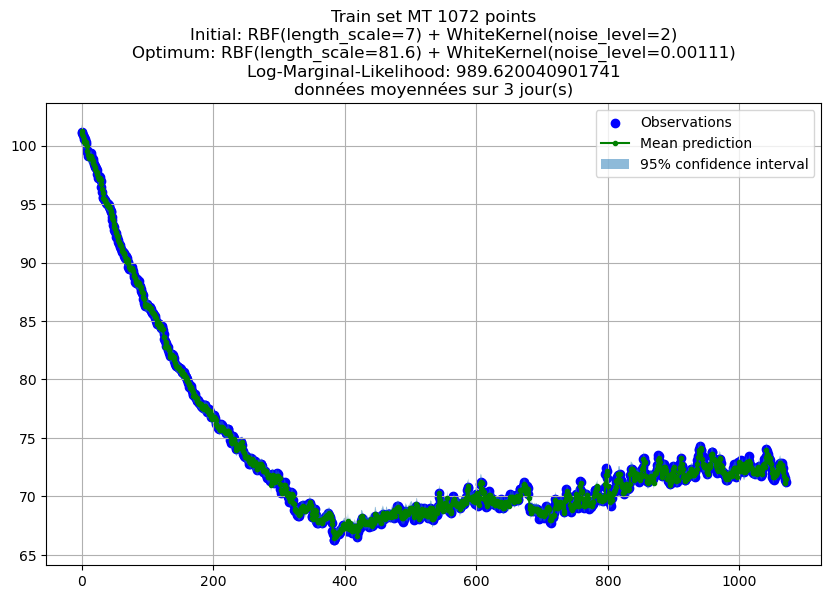

In [67]:
fig, ax = plot_training(X_train, y_mt_train, mean_prediction_mt, std_prediction_mt, gpr_mt, kernel_mt, "Train set MT")

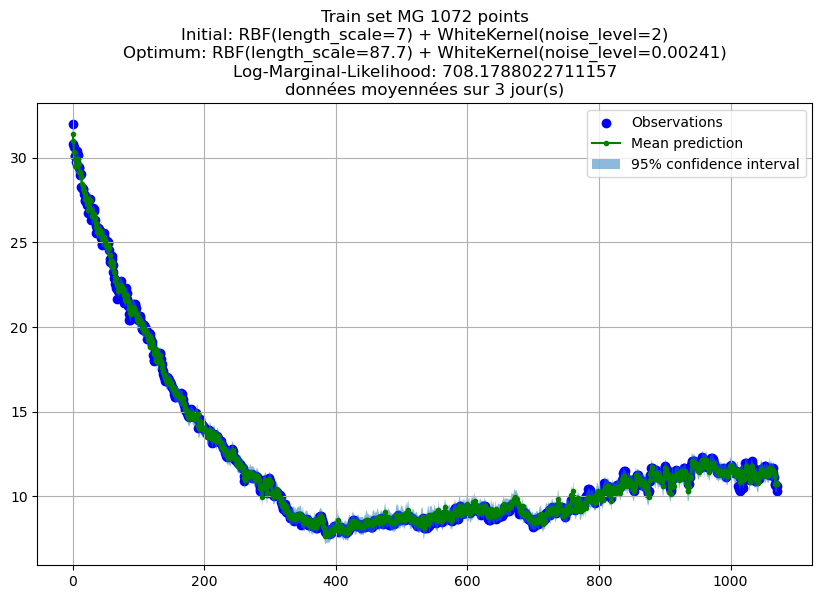

In [68]:
fig, ax = plot_training(X_train, y_mg_train, mean_prediction_mg, std_prediction_mg, gpr_mg, kernel_mg, "Train set MG")

### Inférences J+1

In [69]:
def plot_inference(X_test, y_test, y_mean, y_std, gpr, kernel, titre):
    """utility function pour afficher perf sur test set avec CI"""
    
    fig, ax = plt.subplots(figsize=(10,6))

    abscisses = np.arange(X_test.shape[0])
    ax.scatter(abscisses, y_test, marker='o', label="Observations", color='blue')
    ax.plot(abscisses, y_mean, marker='.', label="Mean prediction", color='green')
    ax.set_title(
        titre +\
        f" {X_test.shape[0]} points\n" +\
        f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: " +\
        f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}\n" +\
        f"données moyennées sur {length_average} jour(s)"
    )
    ax.grid(True)
    ax.fill_between(
        abscisses,
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    
    return fig, ax

In [70]:
mean_prediction_mt, std_prediction_mt = gpr_mt.predict(X_test, return_std=True)

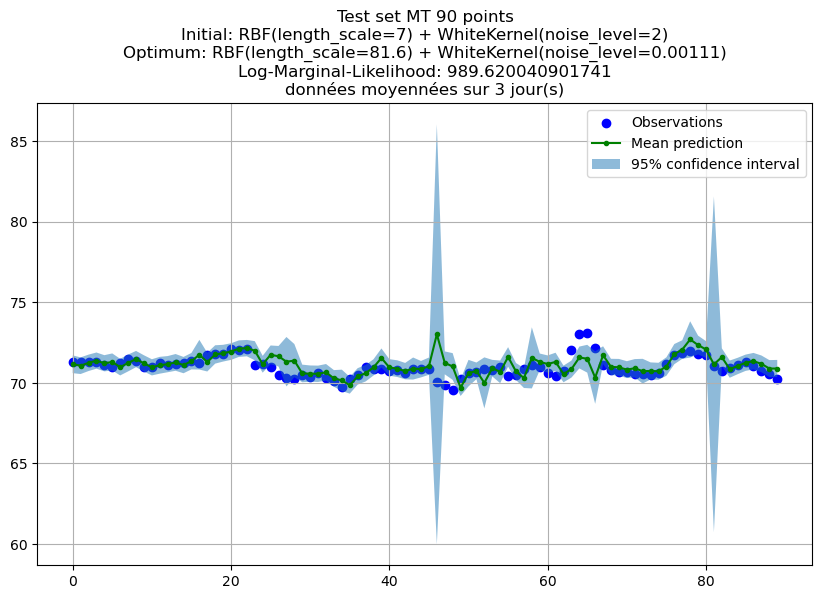

In [71]:
fig, ax = plot_inference(X_test, y_mt_test, mean_prediction_mt, std_prediction_mt, gpr_mt, kernel_mt, "Test set MT")

In [72]:
mean_prediction_mg, std_prediction_mg = gpr_mg.predict(X_test, return_std=True)

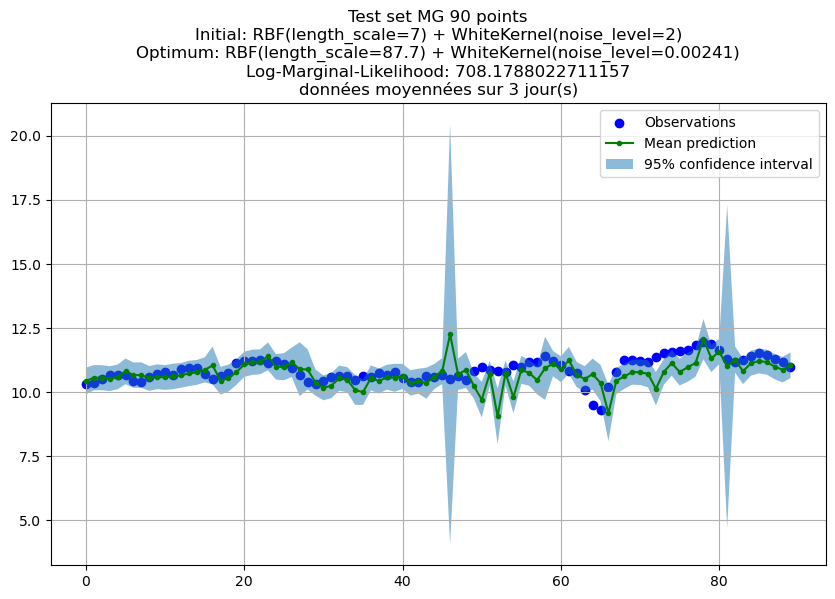

In [73]:
fig, ax = plot_inference(X_test, y_mg_test, mean_prediction_mg, std_prediction_mg, gpr_mg, kernel_mg, "Test set MG")

### Inférence J+1 à J+N

In [74]:
# horizon de prédiction
horizon = 30

In [75]:
X_test

,MT,MG,Cals,Exos
2023-08-20,71.254167,10.290179,1721.400000,146.111190
2023-08-21,71.276786,10.315893,1756.833333,191.209249
2023-08-22,71.274524,10.363810,1894.600000,175.004572
2023-08-23,71.320655,10.522083,1880.033333,278.436046
2023-08-24,71.313433,10.665046,1841.766667,234.717606
...,...,...,...,...
2023-11-13,71.120503,11.383803,1886.600000,202.008472
2023-11-14,71.269074,11.525602,1818.933333,198.528621
2023-11-15,71.032963,11.449259,1778.100000,154.334501
2023-11-16,70.715139,11.291944,1741.266667,262.986866


In [76]:
X_test_pred = X_test[:horizon].copy(deep=True)

In [77]:
y_pred_mt = []  # prédiction MT
y_pred_mg = []  # prédiction MG
y_pred_mt_std = []  # écart-type prédiction MT
y_pred_mg_std = []  # écart-type prédiction MG
next_mt = X_test_pred.iloc[0,0]
next_mg = X_test_pred.iloc[0,1]

In [78]:
for r in range(len(X_test_pred)):
    # on extrait les inputs du jour et on remplace les valeurs MT, MG du jour par celles prédites
    row = X_test_pred.iloc[r:r+1,:].copy(deep=True)
    mini_X_test = pd.DataFrame(
        data = { 'MT' : next_mt,
                'MG' : next_mg,
                'Cals' : row['Cals'],
                'Exos' : row['Exos']}
    )
    # on prédit MT à J+1
    pred_mt, pred_mt_std = gpr_mt.predict(mini_X_test, return_std=True)
    next_mt = pred_mt[0]
    y_pred_mt.append(next_mt)
    y_pred_mt_std.append(pred_mt_std[0])
    # on prédit MG à J+1
    pred_mg, pred_mg_std = gpr_mg.predict(mini_X_test, return_std=True)
    next_mg = pred_mg[0]
    y_pred_mg.append(next_mg)
    y_pred_mg_std.append(pred_mg_std[0])

In [79]:
y_pred_mt_std = np.array(y_pred_mt_std)
y_pred_mg_std = np.array(y_pred_mg_std)

In [80]:
def plot_inference_horizon(X_test, y_test, y_mean, y_std, gpr, kernel, titre):
    """utility function pour afficher perf sur test set avec CI"""
    
    fig, ax = plt.subplots(figsize=(10,6))

    abscisses = np.arange(X_test.shape[0])
    ax.scatter(abscisses, y_test[:horizon], marker='o', label="Observations", color='blue')
    ax.plot(abscisses, y_mean, marker='.', label="Mean prediction", color='green')
    ax.set_title(f"Test set {X_test.shape[0]} points. Inférence J+2 avec valeur prédite à J+1\n" f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
        f"{gpr_mt.log_marginal_likelihood(gpr.kernel_.theta)}\n" \
            f"données moyennées sur {length_average} jours" 
    )
    ax.grid(True)
    ax.fill_between(
        abscisses,
        y_mean - 1.96 * y_std,
        y_mean + 1.96 * y_std,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    
    return fig, ax

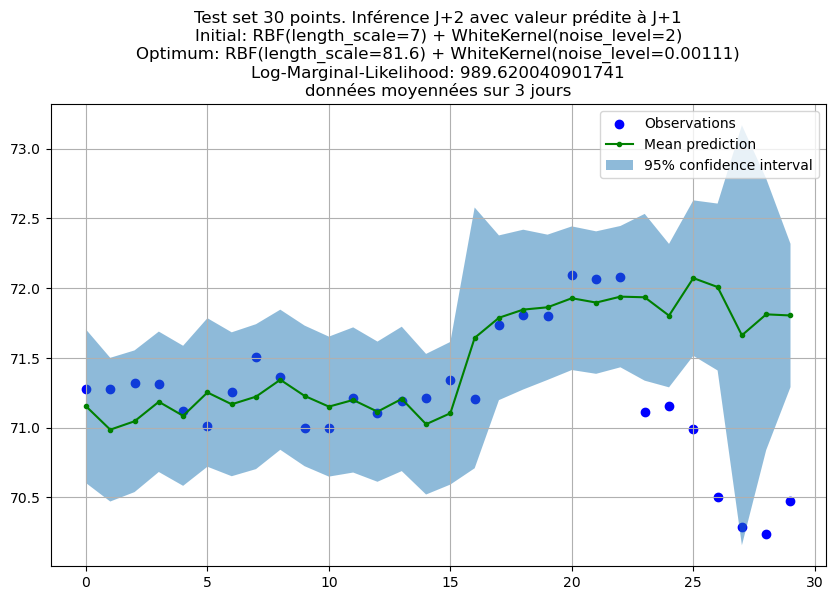

In [81]:
fig, ax = plot_inference_horizon(X_test_pred, y_mt_test, y_pred_mt, y_pred_mt_std, gpr_mt, kernel_mt, "Prediction longue MT")

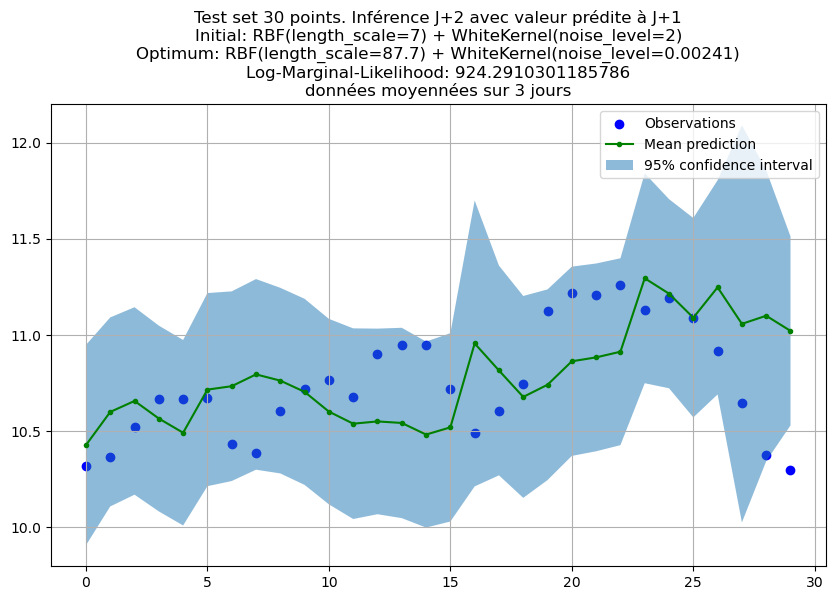

In [82]:
fig, ax = plot_inference_horizon(X_test_pred, y_mg_test, y_pred_mg, y_pred_mg_std, gpr_mg, kernel_mg, "Prediction longue MG")